In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)
np.set_printoptions(precision=2)

In [9]:
data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
data = data.sample(frac=1).reset_index(drop=True)

data = np.array(data)
print(data.shape)

(14799, 785)


In [12]:
# LOAD DATA
np.random.shuffle(data)
m_all, n_all = data.shape

np.random.shuffle(data)

data_dev = data[0:1000]
y_test = data_dev[:, 0] - 1
X_test = data_dev[:, 1:n_all]
X_test = X_test / 255.0 # Normalize the test inputs

data_train = data[1000:m_all]
y_train = data_train[:, 0]
y_train = y_train - 1 # Adjust from 1-26 to 0-25
X_train = data_train[:, 1:n_all]
X_train = X_train / 255.0 # Normalize the train inputs
m, n = X_train.shape
num_classes = 26

In [37]:
# LABELS
def alphabet(label: int) -> str:
    if label >= 1 and label <= 26:
        return chr(label + 64)
    else:
        return ''

In [15]:
print(X_train.shape) # 87799 training examples, 784 (28 x 28) pixel format
print(y_train.shape) # 87799 labels

(13799, 784)
(13799,)


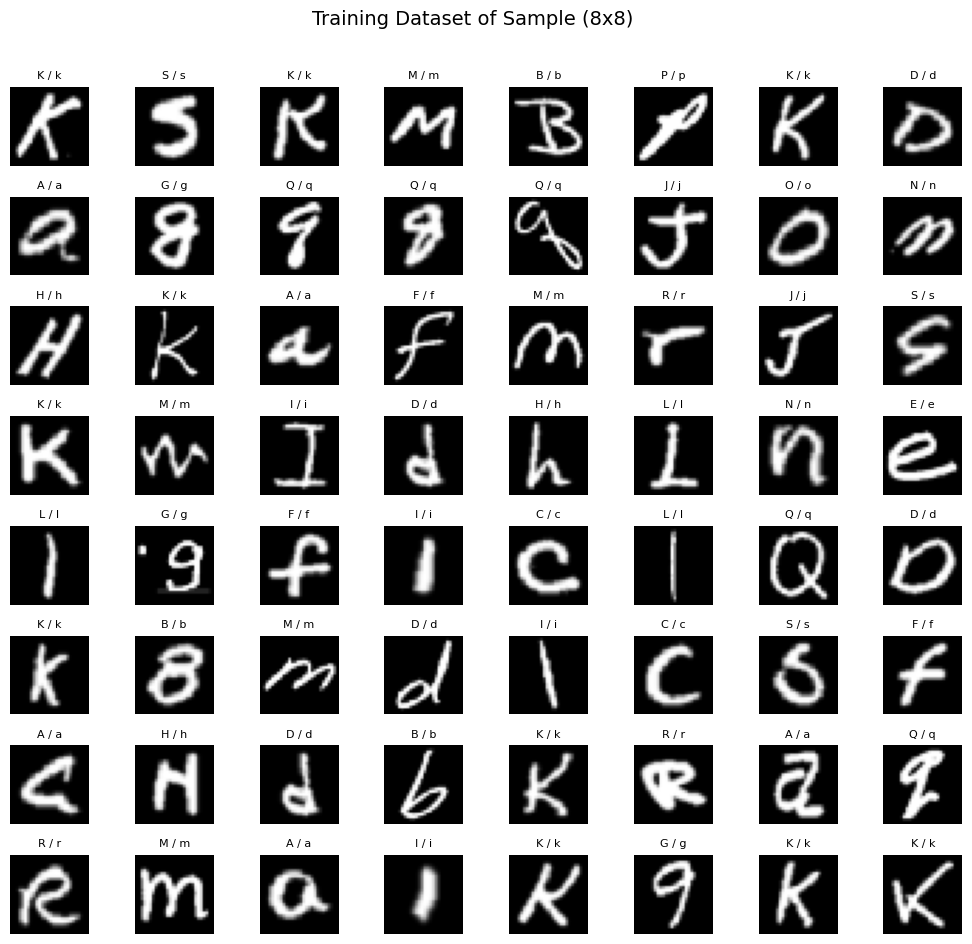

In [21]:
fig, axes = plt.subplots(8,8, figsize=(10,10))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_train[random_index].reshape((28,28)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Display the label above the image
    ax.set_title(alphabet(y_train[random_index] + 1), fontsize=8)
    ax.set_axis_off()
    fig.suptitle("Training Dataset of Sample (8x8)", fontsize=14)

In [32]:
model = Sequential(
    [
        Dense(784, activation='relu', input_shape=(n,)),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(units = num_classes, activation=linear),
    ],
    name="emnist_letters"
)
model.summary()

Model: "emnist_letters"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,086,378 (4.14 MB)

 Trainable params: 1,086,378 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# View Layers
for i, layer in enumerate(model.layers):
    if 'dense' in layer.name:
        w_layer, b_layer = layer.get_weights()
        print(f"Layer: {i} ({layer.name})  Weights: {w_layer.shape} Biases: {b_layer.shape}")
    elif 'dropout' in layer.name:
        print(f"Layer: {i} ({layer.name})  Rate: {layer.rate}")

Layer: 0 (dense_8)  Weights: (784, 784) Biases: (784,)
Layer: 1 (dropout_6)  Rate: 0.5
Layer: 2 (dense_9)  Weights: (784, 512) Biases: (512,)
Layer: 3 (dropout_7)  Rate: 0.5
Layer: 4 (dense_10)  Weights: (512, 128) Biases: (128,)
Layer: 5 (dropout_8)  Rate: 0.5
Layer: 6 (dense_11)  Weights: (128, 26) Biases: (26,)


In [34]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    X_train,y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=32
)

Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2553 - loss: 2.4521 - val_accuracy: 0.7011 - val_loss: 0.9857
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5866 - loss: 1.2839 - val_accuracy: 0.7493 - val_loss: 0.8038
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6774 - loss: 0.9963 - val_accuracy: 0.7855 - val_loss: 0.6744
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7154 - loss: 0.8656 - val_accuracy: 0.7938 - val_loss: 0.6760
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7377 - loss: 0.7913 - val_accuracy: 0.8047 - val_loss: 0.6220
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7630 - loss: 0.7382 - val_accuracy: 0.8207 - val_loss: 0.5760
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7762 - loss: 0.7066 - val_accuracy: 0.8239 - val_loss: 0.5639
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7930 - loss: 0.6340 - val_accu

In [1]:
m_test, n_test = X_test.shape

fig, axes = plt.subplots(8,8, figsize=(10,10))
fig.tight_layout(pad=0.50,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m_test)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_test[random_index].reshape((28,28)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network
    prediction = model.predict(X_test[random_index].reshape(1,784))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)

    # Display the label above the image
    ax.set_title(f"{alphabet(y_test[random_index]+1)} - Pred: {alphabet(yhat+1)}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Multiclass Model Softmax Comparison Test", fontsize=14)
plt.show()

NameError: name 'X_test' is not defined